## 💼 Business Summary: Churn Prediction Strategy

### 🎯 Objective
The primary business goal of this notebook is to **predict customer churn**—identifying which users are likely to cancel their subscription. This enables proactive retention strategies that reduce revenue loss and improve customer lifetime value.

### 📊 How This Goal Is Achieved
This notebook provides a data-driven approach to churn prediction through:

- **Customer Behavior Analysis**: Visualizations reveal how churn correlates with subscription type, device usage, content preferences, and support interactions.
- **Data Preprocessing**: Categorical and numerical features are transformed into a format suitable for machine learning, ensuring consistent and accurate modeling.
- **Model Evaluation**: Multiple classifiers are trained and compared to identify the most effective churn predictor. Metrics like precision and recall help assess business impact.
- **Class Balancing with SMOTE**: Synthetic oversampling ensures that minority churn cases are well-represented, improving model sensitivity to at-risk customers.
- **Threshold Tuning**: Custom decision thresholds allow the business to prioritize either precision (avoiding false alarms) or recall (capturing more churners), depending on strategic goals.

### 📈 Business Impact
By integrating these insights into customer engagement workflows, the company can:

- Launch targeted retention campaigns for high-risk users.
- Personalize offers based on churn drivers (e.g., subscription type or viewing habits).
- Allocate support resources more effectively to reduce dissatisfaction.

This notebook serves as a foundation for building a scalable churn prediction system that aligns with business KPIs.

### 📦 Importing Libraries

This cell imports the core libraries used throughout the notebook:

- `pandas` and `numpy` for data manipulation and numerical operations
- `matplotlib` and `seaborn` for data visualization
- `sklearn` and `xgboost` for preprocessing, modeling, and evaluation
- `imblearn` for handling class imbalance with SMOTE
- Display settings and warning filters are configured to improve notebook readability

In [54]:
# Import libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

# Import tools for splitting the dataset
from sklearn.model_selection import train_test_split

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings for cleaner notebook output
import warnings

# Import preprocessing tools for feature transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Import classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Import evaluation metrics to assess model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Import SMOTE for oversampling the minority class
from imblearn.over_sampling import SMOTE

# Configure display settings for better visibility
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Ignore warnings to keep output clean
warnings.filterwarnings('ignore')

### 📥 Loading the Dataset

This cell reads the training dataset from a CSV file and performs a quick inspection:

- `pd.read_csv()` loads the data into a DataFrame.
- `.shape` reveals the number of rows and columns.
- `.head()` displays the first few records to get a sense of the data structure.

This step is essential for verifying that the data has been loaded correctly and for beginning exploratory analysis.

In [55]:
# Load the training dataset from CSV file
train_df = pd.read_csv("train.csv")

# Display the shape of the dataset (rows, columns)
print('train_df Shape:', train_df.shape)

# Preview the first few rows of the dataset
train_df.head()

train_df Shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,63.531377,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,25.725595,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,57.364061,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,131.537507,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,45.356653,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


### 🧹 Dropping Irrelevant Features

The `CustomerID` column is a unique identifier for each record. While useful for tracking individual customers, it doesn't contribute to the predictive modeling process. Removing it helps streamline the dataset and focus on relevant features.

In [57]:
# Remove the unique identifier column, which is not useful for prediction
train_df = train_df.drop('CustomerID', axis=1)

### 🔍 Checking for Missing Values

This cell verifies the completeness of the dataset by summing all missing values across all columns. A result of `0` confirms that there are no null entries, which means no imputation or cleaning is required before modeling.

In [58]:
# Count total number of missing values in the dataset
print(train_df.isnull().sum().sum())

0


### 🧾 Dataset Structure Overview

This cell provides a concise summary of the dataset:

- Displays the number of entries and columns
- Shows non-null counts to confirm data completeness
- Lists data types for each feature

This overview helps identify which features are numerical, categorical, or potentially need transformation before modeling.

In [59]:
# Display dataset structure, including column types and non-null counts
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                243787 non-null  f

### 📊 Summary Statistics of Numerical Features

This cell provides descriptive statistics for all numerical columns in the dataset:

- `count`, `mean`, and `std` show the distribution and variability of each feature
- `min`, `25%`, `50%`, `75%`, and `max` help identify the range and potential outliers
- These insights are useful for understanding feature scales and guiding preprocessing decisions like normalization or binning

In [60]:
# Display summary statistics for numerical features in the dataset
train_df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


### 📉 Visualizing Churn Distribution

This pie chart illustrates the proportion of customers who churned versus those who stayed. It helps assess class imbalance, which is crucial for choosing appropriate modeling and resampling techniques.

- `value_counts()` counts the number of churned and non-churned customers.
- `plot(kind='pie')` creates a pie chart with custom labels and colors.
- `autopct` displays percentages, and `startangle` improves visual orientation.

<Axes: ylabel='count'>

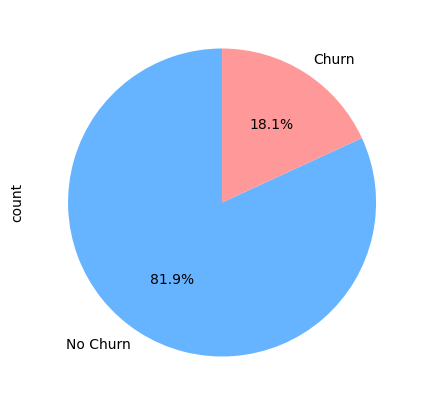

In [61]:
# Plot the distribution of churned vs. non-churned customers as a pie chart
train_df['Churn'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',           # Display percentage values on the chart
    startangle=90,               # Rotate chart for better readability
    figsize=(5, 5),              # Set figure size
    labels=['No Churn', 'Churn'],# Define custom labels for clarity
    colors=['#66b3ff', '#ff9999']# Use distinct colors for each class
)

### 🧮 Separating Feature Types

To prepare for preprocessing, we categorize features into:

- **Categorical features**: Identified by `object` or `category` data types. These will be encoded using techniques like One-Hot or Ordinal Encoding.
- **Numerical features**: Identified by `number` data types. These will be scaled or normalized as needed.

The target variable `Churn` is excluded from both lists since it's the label we aim to predict.

In [8]:
# Identify categorical features based on data type, excluding the target column
cat_features = train_df.drop(['Churn'], axis=1).select_dtypes(include=['object', 'category']).columns.to_list()

# Identify numerical features based on data type, excluding the target column
num_features = train_df.drop(['Churn'], axis=1).select_dtypes(include=['number']).columns.to_list()

### 🔗 Correlation Analysis of Numerical Features

This heatmap visualizes the linear relationships between numerical features and the target variable `Churn`. By converting `Churn` to an integer, we include it in the correlation matrix to identify which features are most predictive.

- Strong positive or negative correlations with `Churn` may indicate valuable predictors.
- This analysis helps guide feature selection and engineering decisions.

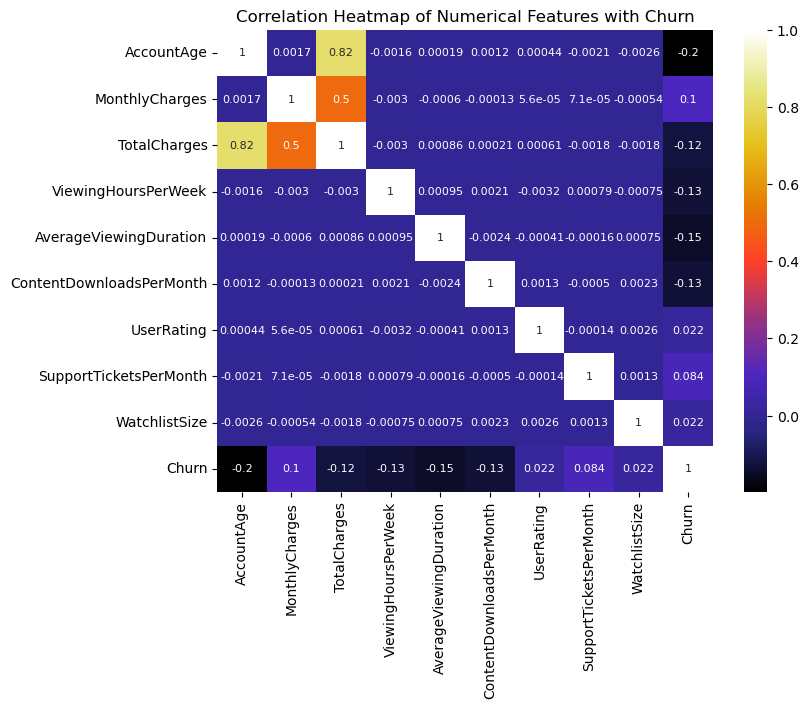

In [52]:
# Combine numerical features with the target variable for correlation analysis
corr_matrix = pd.concat([train_df[num_features], train_df["Churn"].astype(int)], axis=1).corr()

# Create a heatmap to visualize correlations between features and churn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='CMRmap', annot=True, annot_kws={"size": 8})
plt.title("Correlation Heatmap of Numerical Features with Churn")
plt.show()

### 📊 Distribution of Continuous Features by Churn

This visualization compares the distributions of continuous numerical features between churned and non-churned customers:

- **Boxplots** show the spread and central tendency of each feature across churn classes, helping detect shifts or outliers.
- **Histograms** reveal the overall distribution and density of values, stacked by churn status.

Only features with at least 10 unique values are included to ensure meaningful visual separation.

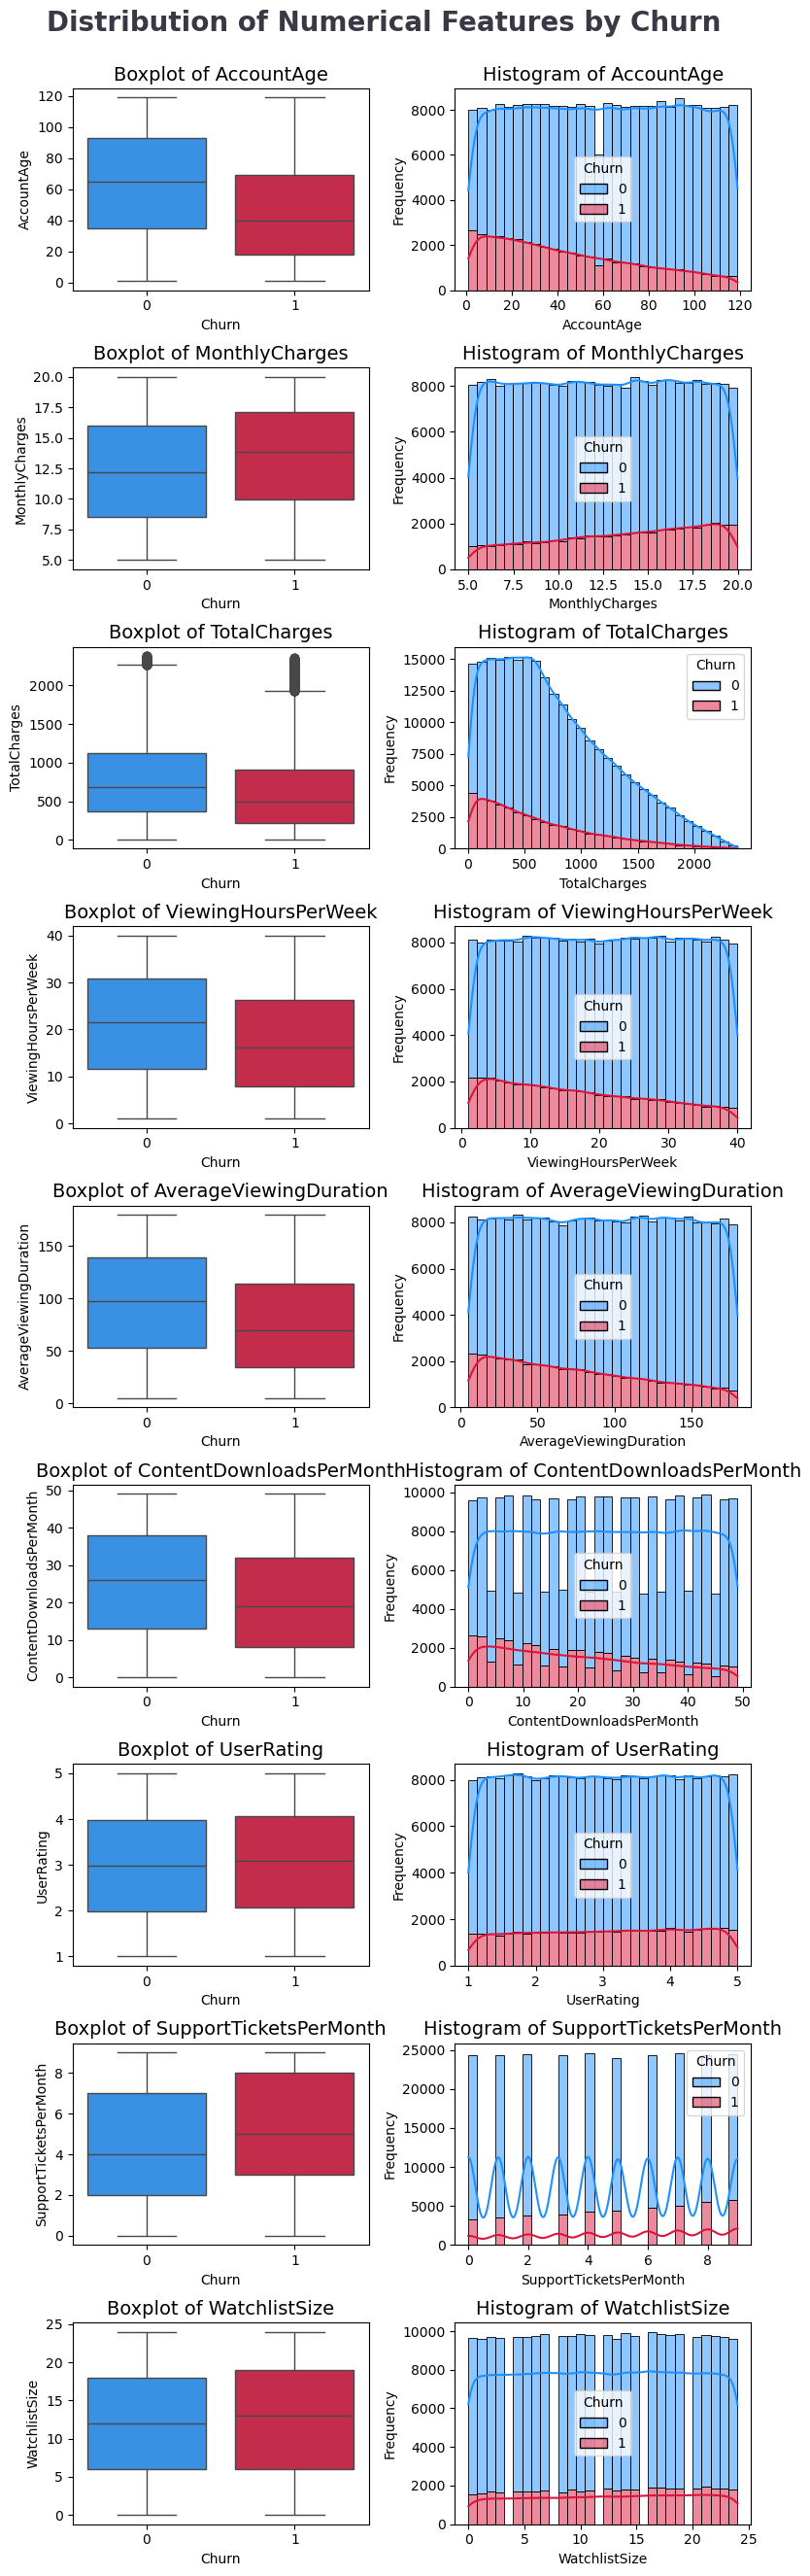

In [62]:
# Select continuous numerical features with sufficient variability
continuous_features = [feature for feature in num_features if train_df[feature].nunique() >= 10]

# Define color palette for churn classes: blue for non-churned, red for churned
clr1 = ['#1E90FF', '#DC143C']

# Create subplots: one row per feature, two columns for boxplot and histogram
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(8, 3 * len(continuous_features)))
fig.suptitle('Distribution of Numerical Features by Churn', fontsize=20, fontweight='bold', ha='center', color='#3C3744')

# Loop through each continuous feature to generate plots
for i, col in enumerate(continuous_features):
    # Boxplot to compare feature distribution across churn classes
    sns.boxplot(data=train_df, x='Churn', y=col, palette=clr1, ax=ax[i, 0])
    ax[i, 0].set_title(f'Boxplot of {col}', fontsize=14)
    ax[i, 0].set_xlabel('Churn')
    ax[i, 0].set_ylabel(col)

    # Histogram to visualize feature distribution stacked by churn status
    sns.histplot(data=train_df, x=col, hue='Churn', bins=30, kde=True, multiple='stack', palette=clr1, ax=ax[i, 1])
    ax[i, 1].set_title(f'Histogram of {col}', fontsize=14)
    ax[i, 1].set_xlabel(col)
    ax[i, 1].set_ylabel('Frequency')

# Adjust layout for better spacing and visibility
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### 🧾 Categorical Feature Distributions and Churn Breakdown

This visualization explores how categorical features are distributed overall and how they relate to churn:

- **Left column**: Count plots show the frequency of each category across the entire dataset.
- **Right column**: Count plots with `hue='Churn'` reveal how churn varies across categories.

This analysis helps identify categorical variables that may be strong predictors of churn, such as subscription type or device usage.

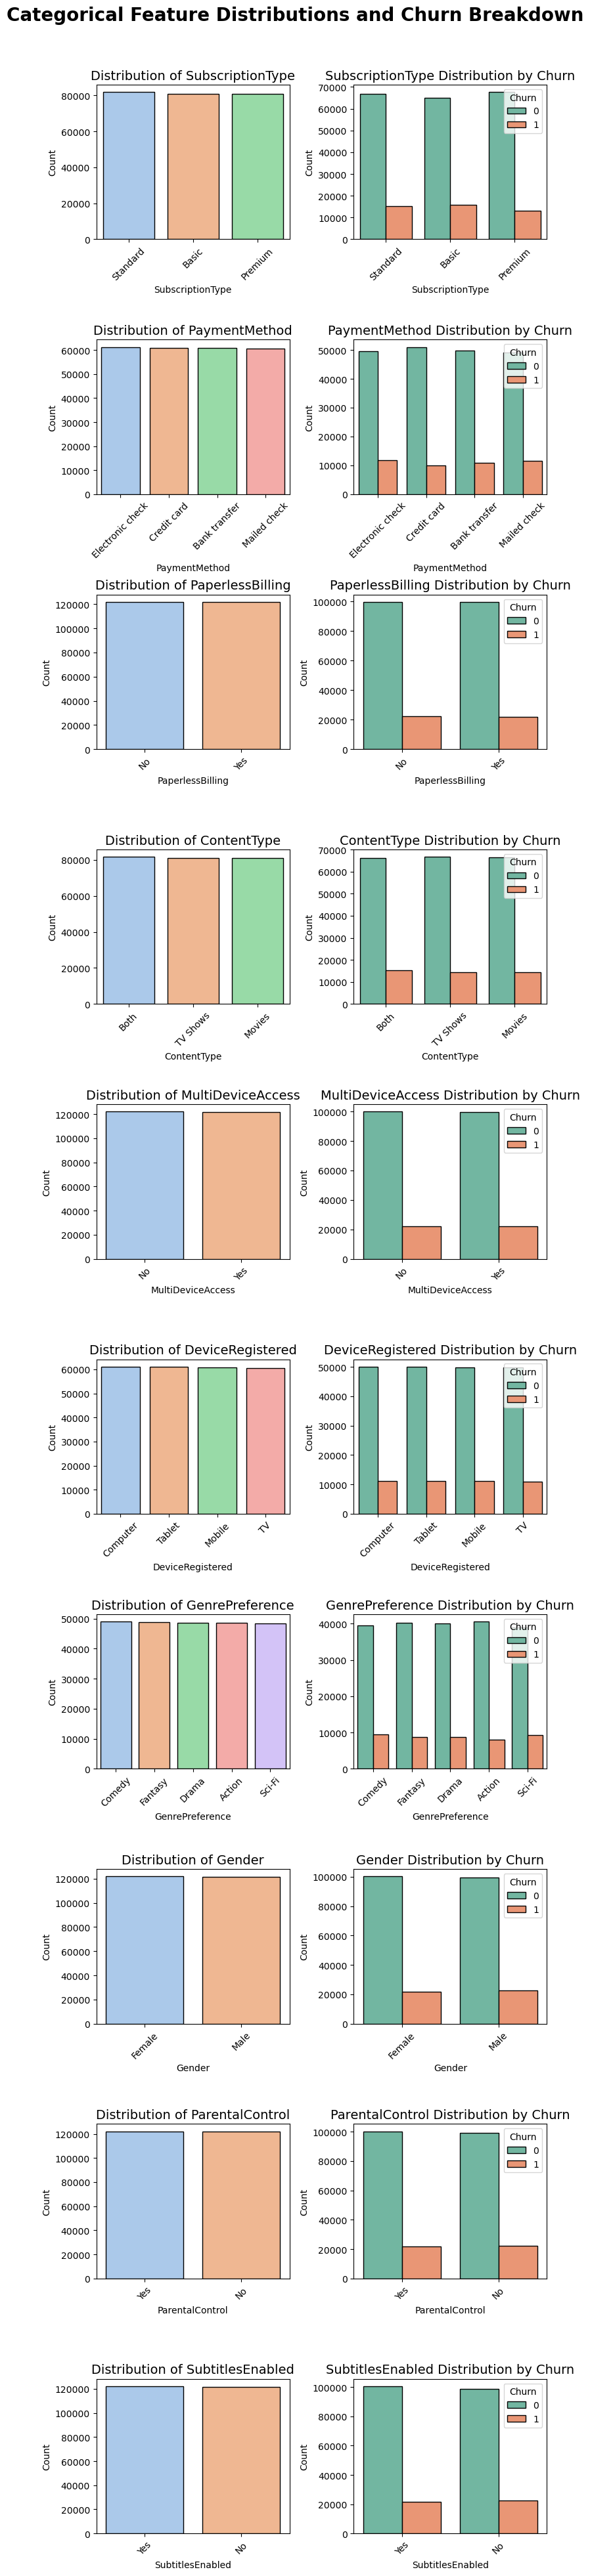

In [63]:
# Determine the number of categorical features to set up the plot grid
n_rows = len(cat_features)

# Create subplots with one row per feature and two columns for comparison
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 4 * n_rows))
fig.suptitle('Categorical Feature Distributions and Churn Breakdown', fontsize=20, fontweight='bold', ha='center')

# Loop through each categorical feature to generate plots
for i, feature in enumerate(cat_features):
    # Plot overall distribution of the feature
    sns.countplot(data=train_df, x=feature, order=train_df[feature].value_counts().index,
                  ax=axes[i, 0], palette='pastel', edgecolor='black')
    axes[i, 0].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].set_ylabel('Count')

    # Plot distribution of the feature segmented by churn status
    sns.countplot(data=train_df, x=feature, hue='Churn', order=train_df[feature].value_counts().index,
                  ax=axes[i, 1], palette='Set2', edgecolor='black')
    axes[i, 1].set_title(f'{feature} Distribution by Churn', fontsize=14)
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].set_ylabel('Count')

# Adjust layout for better spacing and visibility
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### 🧪 Preprocessing Pipeline for Churn Prediction

This function prepares a dataset for machine learning by:

- Separating features and target (if specified)
- Identifying categorical and numerical columns
- Applying appropriate transformations:
  - **Ordinal Encoding** for ordered categories (e.g., `SubscriptionType`)
  - **One-Hot Encoding** for nominal categorical features
  - **Standard Scaling** for numerical features
- Returning a transformed DataFrame with all features and the target column (if provided)

This modular pipeline ensures consistent preprocessing across training and inference stages.

In [64]:
def preprocess_pipeline(df_work_in, target_column=None):
    # Separate features and target if specified
    if target_column:
        X = df_work_in.drop(columns=[target_column])
        y = df_work_in[target_column]
    else:
        X = df_work_in
        y = None

    # Identify feature types
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_features = X.select_dtypes(include=['number']).columns.tolist()

    # Define categorical encoding strategies
    ord_cat_features = ['SubscriptionType']
    ord_order = [['Basic', 'Standard', 'Premium']]
    ohe_cat_features = [col for col in cat_features if col not in ord_cat_features]

    # Define transformers
    ordinal_encoder = OrdinalEncoder(categories=ord_order)
    onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
    scaler = StandardScaler()

    # Combine transformations
    preprocessor = ColumnTransformer(transformers=[
        ('ord', ordinal_encoder, ord_cat_features),
        ('ohe', onehot_encoder, ohe_cat_features),
        ('scaler', scaler, num_features)
    ])

    # Build pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit and transform the data
    X_processed = pipeline.fit_transform(X)

    # Retrieve feature names
    ord_names = ord_cat_features
    ohe_names = pipeline.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names_out(ohe_cat_features)
    num_names = num_features
    all_feature_names = ord_names + list(ohe_names) + num_names

    # Convert to DataFrame
    X_df = pd.DataFrame(X_processed, columns=all_feature_names, index=X.index)

    # Reattach target column if available
    if y is not None:
        X_df[target_column] = y

    return X_df

### 📥 Load and Preview the Dataset

This cell performs the initial data loading and inspection:

- Reads the training dataset from a CSV file.
- Removes the `CustomerID` column, which is a unique identifier and not useful for modeling.
- Displays the shape of the dataset and previews the first few rows.

This step sets the foundation for further analysis and preprocessing.

In [65]:
# Load the training dataset from CSV
train_df = pd.read_csv("train.csv")

# Remove the CustomerID column since it's not informative for modeling
train_df = train_df.drop('CustomerID', axis=1)

# Print the shape of the dataset to understand its size
print('train_df Shape:', train_df.shape)

# Display the first few rows to get a quick look at the data
train_df.head()

train_df Shape: (243787, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,63.531377,10,Sci-Fi,2.176498,4,Male,3,No,No,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,25.725595,18,Action,3.478632,8,Male,23,No,Yes,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,57.364061,23,Fantasy,4.238824,6,Male,1,Yes,Yes,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,131.537507,30,Drama,4.276013,2,Male,24,Yes,Yes,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,45.356653,20,Comedy,3.616170,4,Female,0,No,No,0


### 🧼 Apply Preprocessing Pipeline

This step transforms the raw training data into a machine-learning-ready format:

- Applies the `preprocess_pipeline` function to:
  - Encode categorical features (ordinal and one-hot)
  - Scale numerical features
- Separates and retains the target column (`Churn`)
- Returns a clean DataFrame with transformed features and consistent column names

This ensures that the data is standardized and encoded properly for model training.

In [14]:
# Apply the preprocessing pipeline to the training dataset
# This includes encoding categorical features and scaling numerical ones
train_df_preprocessed = preprocess_pipeline(train_df, 'Churn')

### 🧪 Stratified Sampling and Churn Distribution Visualization

This step performs a stratified sampling of the preprocessed dataset:

- Samples 20% of the data from each class in the `Churn` column to maintain class balance.
- Visualizes the class distribution using a pie chart to confirm proportional representation.

This is useful for creating a smaller, balanced subset for quick experimentation or visualization.

<Axes: ylabel='count'>

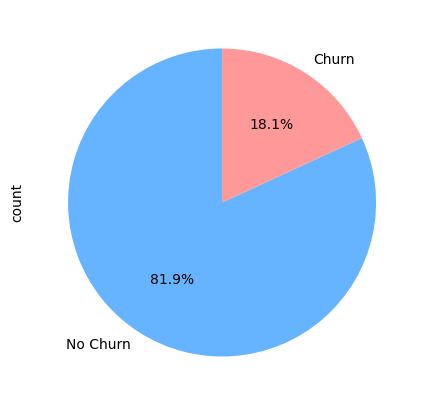

In [66]:
# Sample 20% of the data from each churn class to maintain class proportions
stratified_sample_df = train_df_preprocessed.groupby('Churn', group_keys=False).apply(
    lambda x: x.sample(frac=0.2, random_state=42)
)

# Plot the churn distribution in the sampled dataset using a pie chart
stratified_sample_df['Churn'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',               # Display percentage labels with one decimal
    startangle=90,                   # Rotate chart for better visual orientation
    figsize=(5, 5),                  # Set figure size
    labels=['No Churn', 'Churn'],    # Custom labels for clarity
    colors=['#66b3ff', '#ff9999']    # Custom colors for visual appeal
)

### 🤖 Train and Evaluate Multiple Classifiers

This function trains and evaluates several classification models on the dataset:

- Splits the data into training and test sets (80/20 split)
- Trains four classifiers:
  - Random Forest
  - Decision Tree
  - Logistic Regression
  - XGBoost
- Computes key performance metrics:
  - Accuracy, Precision, Recall, F1 Score, ROC-AUC
- Plots ROC curves to visualize model performance
- Returns a DataFrame of metrics and a dictionary of trained models

This step helps compare model effectiveness and choose the best-performing one.

In [67]:
def train_and_evaluate_models(df, target_column='Churn'):
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a set of classifiers to evaluate
    classifiers = {
        'RandomForest': RandomForestClassifier(),
        'DecisionTree': DecisionTreeClassifier(),
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    # Initialize containers for results and trained models
    results = []
    trained_models = {}

    # Set up ROC curve plot
    plt.figure(figsize=(8, 6))

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        trained_models[name] = clf

        # Predict labels and probabilities
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

        # Calculate evaluation metrics
        metrics = {
            'Model': name,
            'Accuracy': round(accuracy_score(y_test, y_pred), 4),
            'Precision': round(precision_score(y_test, y_pred), 4),
            'Recall': round(recall_score(y_test, y_pred), 4),
            'F1 Score': round(f1_score(y_test, y_pred), 4),
            'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4)
        }
        results.append(metrics)

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {metrics['ROC-AUC']:.2f})")

    # Finalize ROC plot
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classifiers')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Return evaluation results and trained models
    return pd.DataFrame(results), trained_models

### 📈 Train Models and Display Evaluation Metrics

This step executes the model training and evaluation pipeline:

- Trains four classifiers on the stratified sample:
  - Random Forest
  - Decision Tree
  - Logistic Regression
  - XGBoost
- Collects performance metrics for each model:
  - Accuracy, Precision, Recall, F1 Score, ROC-AUC
- Displays the results in a DataFrame for easy comparison

This helps identify which model performs best on the sampled data.

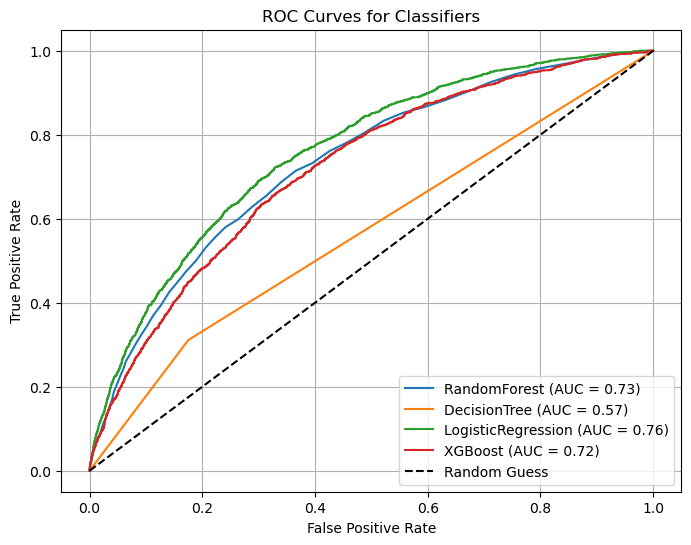

                Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
0        RandomForest    0.8163     0.5301  0.0731    0.1285   0.7334
1        DecisionTree    0.7296     0.2875  0.3112    0.2989   0.5679
2  LogisticRegression    0.8208     0.5747  0.1235    0.2033   0.7599
3             XGBoost    0.8122     0.4794  0.1611    0.2412   0.7202


In [68]:
# Train models and evaluate their performance on the stratified sample
results_df, models_trained = train_and_evaluate_models(stratified_sample_df)

# Display the evaluation metrics for each model
print(results_df)

### ⚖️ Balance Classes with SMOTE and Retrain Models

This step addresses class imbalance using SMOTE (Synthetic Minority Over-sampling Technique):

- Separates features and target from the stratified sample.
- Applies SMOTE to generate synthetic examples of the minority class (`Churn = 1`).
- Combines the resampled features and target into a new DataFrame.
- Retrains the same set of classifiers on the balanced dataset.
- Displays the new shape and evaluation metrics.

This helps improve model performance, especially recall and ROC-AUC, by ensuring balanced training data.

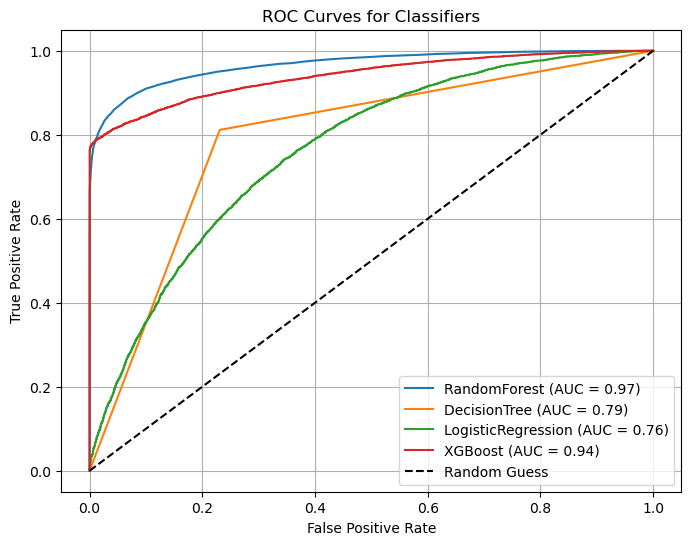

(79842, 28)
                Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
0        RandomForest    0.9087     0.9357  0.8792    0.9066   0.9664
1        DecisionTree    0.7904     0.7811  0.8115    0.7960   0.7902
2  LogisticRegression    0.6955     0.6950  0.7052    0.7001   0.7637
3             XGBoost    0.8853     0.9537  0.8119    0.8771   0.9394


In [69]:
# Separate features and target from the stratified sample
X = stratified_sample_df.drop(columns=['Churn'])
y = stratified_sample_df['Churn']

# Apply SMOTE to balance the classes by oversampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled features and target into a new DataFrame
smote_df = pd.DataFrame(X_resampled, columns=X.columns)
smote_df['Churn'] = y_resampled

# Train and evaluate models on the balanced dataset
results_smote, models_trained_smote = train_and_evaluate_models(smote_df)

# Display the shape of the balanced dataset and the evaluation results
print(smote_df.shape)
print(results_smote)

### 🎯 Threshold Tuning for Random Forest Predictions

This step explores how changing the classification threshold affects model performance:

- Uses the trained Random Forest model from the SMOTE-balanced dataset.
- Predicts churn probabilities on the test set.
- Iterates through thresholds from 0.5 to 0.3.
- For each threshold:
  - Converts probabilities to binary predictions.
  - Computes Precision, Recall, and F1 Score.
  - Displays the confusion matrix.

This helps find a threshold that balances false positives and false negatives based on business priorities.

In [70]:
# Retrieve the trained Random Forest model from the SMOTE-balanced training
rf_model = models_trained_smote['RandomForest']

# Prepare feature matrix and target vector from the stratified sample
X = stratified_sample_df.drop('Churn', axis=1)
y = stratified_sample_df['Churn']

# Split into training and test sets with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Predict churn probabilities on the test set
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance at different classification thresholds
for threshold in np.arange(0.5, 0.2, -0.1):
    y_pred_custom = (y_probs >= threshold).astype(int)

    print(f"\n🔎 Threshold: {threshold:.1f}")
    print(f"Precision: {precision_score(y_test, y_pred_custom):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred_custom):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred_custom):.4f}")

    # Display confusion matrix components
    cm = confusion_matrix(y_test, y_pred_custom)
    print("Confusion Matrix:")
    print(f"TN: {cm[0,0]}  FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}  TP: {cm[1,1]}")


🔎 Threshold: 0.5
Precision: 0.9561
Recall:    0.8874
F1 Score:  0.9205
Confusion Matrix:
TN: 7913  FP: 72
FN: 199  TP: 1568

🔎 Threshold: 0.4
Precision: 0.9166
Recall:    0.9327
F1 Score:  0.9245
Confusion Matrix:
TN: 7835  FP: 150
FN: 119  TP: 1648

🔎 Threshold: 0.3
Precision: 0.8493
Recall:    0.9666
F1 Score:  0.9042
Confusion Matrix:
TN: 7682  FP: 303
FN: 59  TP: 1708
